5.664788732394367


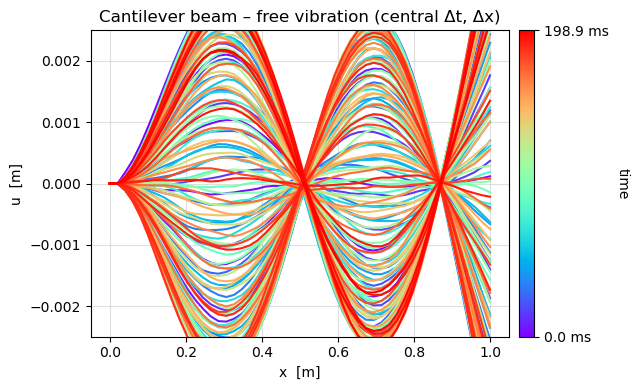

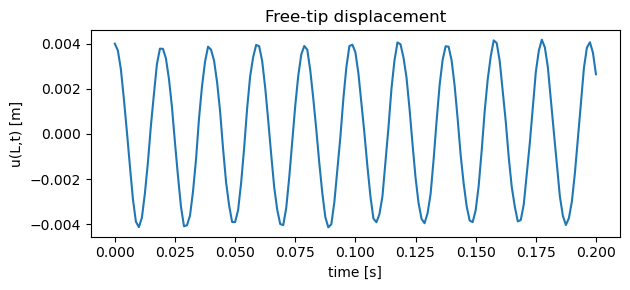

In [214]:
"""
AE 370  •  Project 2
Euler–Bernoulli cantilever beam – free vibration
------------------------------------------------
* Spatial discretisation  : centred 5‑point FD for u''''(x)
* Time integration        : explicit central difference (leap‑frog)
* Boundary conditions     : clamped (x=0)  +  free (x=L)
  – u(0)=0, u_x(0)=0
  – u_xx(L)=0, u_xxx(L)=0
The ghost‑node eliminations that enforce the BCs give tailored
rows in the D4 matrix at i = 1, N‑2, N‑1 (see build_D4_cantilever).
Author : <your name>, 12 May 2025
--------------------------------------------------------------
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1.  User‑visible parameters (edit here for parametric sweeps)
# ------------------------------------------------------------
L       = 1.0          # [m] beam length
E       = 70e9         # [Pa] Young’s modulus
I       = 1.0e-10      # [m^4] area moment of inertia
A_cs    = 1.0e-4      # [m^2] cross‑sectional area
rho     = 2700.0       # [kg m‑3] density
sigma0  = 0.10 * L     # initial Gaussian bump width  (σ = 0.1 L)

N       = 50          # total grid nodes  (≥ 6 so central stencil fits)
t_end   = 0.2       # [s] final time
dt      = None        # time step; set None → code picks a conservative stable dt
store_every = 500      # save every k‑th step for plotting
mode = 1
TE = []
# ------------------------------------------------------------


# ---- helper: build fourth‑derivative matrix with cantilever BC ----
def build_D4_cantilever(N, dx):
    """
    Returns dense (N×N) finite‑difference matrix that approximates u''''.
    Interior rows use the standard 5‑point stencil (1 ‑4 6 ‑4 1)/dx⁴.
    Rows near the ends are modified by eliminating ghost nodes with
    the cantilever boundary conditions:
        x=0 : u = 0  AND  u_x = 0
        x=L : u_xx = 0  AND  u_xxx = 0
    """
    D4 = np.zeros((N, N))
    c  = 1.0 / dx**4

    # interior rows (i = 2 … N‑3)
    for i in range(2, N-2):
        D4[i, i-2:i+3] = c * np.array([1,-4,6,-4,1])

    # row 1  (uses u_{‑1} = u_1 from slope BC)
    D4[1,0] = -4*c
    D4[1,1] =  7*c
    D4[1,2] = -4*c
    D4[1,3] =  c

    # rows at free end (derived with u_xx = 0 & u_xxx = 0)
    # i = N‑2
    D4[N-2, N-4] =  c
    D4[N-2, N-3] = -4*c
    D4[N-2, N-2] =  5*c
    D4[N-2, N-1] = -2*c
    # i = N‑1
    D4[N-1, N-3] =  2*c
    D4[N-1, N-2] = -4*c
    D4[N-1, N-1] =  2*c

    # row 0 is left zero – u(0)=0 is enforced explicitly each step
    return D4

beta = {1:1.87510407,
        2:4.69409113,
        3:7.85475744,
        4:10.9955407}

def mode_shape(n, x, L):
    β = beta[n]
    C = (np.cosh(β) - np.cos(β)) / (np.sinh(β) + np.sin(β))
    ξ = x / L
    return (np.cosh(β*ξ) - np.cos(β*ξ)
            - C*(np.sinh(β*ξ) - np.sin(β*ξ)))
def central_step(u_prev, u_curr, A, dt):
    """Leap‑frog update  u^{k+1} = 2u^k ‑ u^{k‑1} + dt² A u^k"""
    return 2.0*u_curr - u_prev + (dt**2) * (A @ u_curr)


def simulate():
    # spatial grid -----------------------------------------------------
    x  = np.linspace(0.0, L, N)
    dx = x[1] - x[0]

    # build spatial operator  (∂²u/∂t² = A u) -------------------------
    D4   = build_D4_cantilever(N, dx)
    coef = - (E*I) / (rho*A_cs)         # sign gives A < 0 (restoring)
    A_mat = coef * D4                   # shape (N,N)

    # choose stable dt if not supplied -------------------------------
    global dt
    if dt is None:
        # crude but safe estimate: ω_max ≈ π²/dx² * √(EI/ρA)
        omega_max = (np.pi**2 / dx**2) * np.sqrt(E*I/(rho*A_cs))
        dt = 0.3 / omega_max            # CFL‑like safety factor

    n_steps = int(np.ceil(t_end / dt))
    dt      = t_end / n_steps           # make dt divide t_end exactly

    # initial condition ----------------------------------------------
    

    # Usage inside your simulate():
    A = 0.002
    u0 = A * mode_shape(3, x, L)
    # β1 = 1.87510407
    # C = (np.cosh(β1)-np.cos(β1)) / (np.sinh(β1)+np.sin(β1))
    # ξ = x/L
    # φ1 = (np.cosh(β1*ξ)-np.cos(β1*ξ)
    #      - C*(np.sinh(β1*ξ)-np.sin(β1*ξ)))
    # A = 0.002
    # u0 = A * φ1
    # A = 0.002
    # ξ = x/L
    # u0 = A*(10*ξ**3 - 15*ξ**4 + 6*ξ**5)
    #u0   = 0.002 * np.exp(-((x - L/2.0)**2) / sigma0**2)
    u0[0] = u0[1] = 0.0                 # enforce clamped end

    # central difference needs “u^{‑1}”  (Taylor series, v0 = 0) ------
    u_tt0  = A_mat @ u0
    u_prev = u0 + 0.5 * dt**2 * u_tt0   # u^{‑1}
    u_curr = u0.copy()

    # storage arrays --------------------------------------------------
    snaps, times = [u_curr.copy()], [0.0]
    tip_trace = [u_curr[-1]]

    # time‑march ------------------------------------------------------
    for k in range(1, n_steps+1):
        u_next = central_step(u_prev, u_curr, A_mat, dt)
        KE = 0.5*rho*A_cs*np.trapz((u_curr-u_prev)**2, x)/dt**2
        PE = 0.5*E*I*np.trapz((np.gradient(np.gradient(u_curr,dx),dx))**2, x)
        TE.append(PE+KE)
        # (re‑)enforce clamped BC at each step
        u_next[0] = u_next[1] = 0.0

        if k % store_every == 0:
            snaps.append(u_next.copy())
            times.append(k*dt)
            tip_trace.append(u_next[-1])
        
        u_prev, u_curr = u_curr, u_next
    
    return x, np.asarray(times), np.vstack(snaps), np.array(tip_trace)

# ---------------------------------------------------------------------
# main: run + plot a few snapshots
# ---------------------------------------------------------------------
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

if __name__ == "__main__":
    x, t_save, U, u_tip= simulate()
    minidx = np.argmin(u_tip)  
    
    # half‑period time
    t_half = t_save[minidx]
    
    # frequency
    f_i = 1.0 / (2 * t_half)
    print(f_i)
    # lock y-range
    y_min, y_max = U.min(), U.max()

    # create figure + axes
    fig, ax = plt.subplots(figsize=(6.5,4))

    cmap  = plt.get_cmap('rainbow')
    norm  = Normalize(vmin=t_save.min(), vmax=t_save.max())
    colors = cmap(norm(t_save))    # directly normalize your t_save array

    # plot all curves
    for ui, ti, c in zip(U, t_save, colors):
        ax.plot(x, ui, color=c)
    ax.set_ylim(-0.0025, 0.0025)
    ax.set_xlabel("x  [m]")
    ax.set_ylabel("u  [m]")
    ax.set_title("Cantilever beam – free vibration (central Δt, Δx)")
    ax.grid(True, alpha=0.4)

    # build the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # **pass ax=...** so Matplotlib knows where to draw it
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("time", rotation=270, labelpad=15)
    cbar.set_ticks([t_save.min(), t_save.max()])
    cbar.set_ticklabels([
        f"{t_save.min()*1e3:.1f} ms", 
        f"{t_save.max()*1e3:.1f} ms"
    ])

    plt.tight_layout()
    plt.show()
     # free-tip history
    plt.figure(figsize=(6.4, 3))
    plt.plot(np.linspace(0, t_end, len(u_tip)), u_tip)
    plt.xlabel("time [s]"); plt.ylabel("u(L,t) [m]")
    plt.title("Free-tip displacement")
    plt.tight_layout()
    plt.show()
    #print("maximum % deviation in total energy: ", 100*(max(TE) - min(TE)) / min(TE), "%")
    #print(dt)
    #2.91, #4.52, #5.66
    

Analytic half‐period T1/2 = 0.087741 s


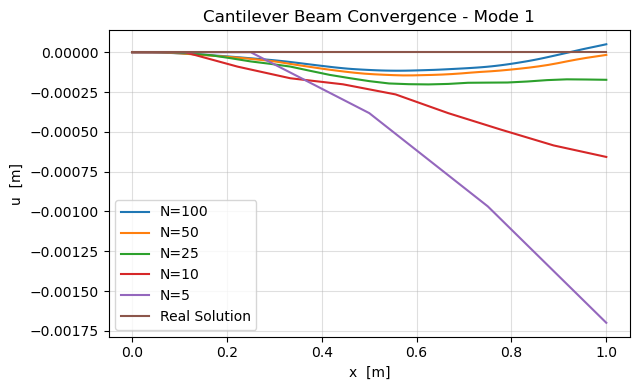

In [191]:


# create figure + axes
fig, ax = plt.subplots(figsize=(6.5,4))
# ------------------------------------------------------------
#  Find the “reverse” time for mode 1 and pull out that snapshot
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# 1) analytic half‐period for mode 1
beta1   = beta[1]   # 1.87510407
omega1  = (beta1**2 / L**2) * np.sqrt(E*I/(rho*A_cs))
t_half  = np.pi / (2*omega1)
print(f"Analytic half‐period T1/2 = {t_half:.6f} s")

# 2) find closest saved time
idx     = np.argmin(np.abs(t_save - t_half))
N = 100
x, t_save, ui100, u_tip= simulate()
ax.plot(x, ui100[idx], label="N=100")
N = 50
x, t_save, ui50, u_tip= simulate()
ax.plot(x, ui50[idx], label="N=50")
N = 25
x, t_save, ui25, u_tip= simulate()
ax.plot(x, ui25[idx], label="N=25")
N = 10
x, t_save, ui10, u_tip= simulate()
ax.plot(x, ui10[idx], label="N=10")
N = 5
x, t_save, ui5, u_tip= simulate()
ax.plot(x, ui5[idx], label="N=5")
A = 0.002
u0 = 0 * mode_shape(1, x, L)
ax.plot(x, -u0, label="Real Solution") 
ax.set_xlabel("x  [m]")
ax.set_ylabel("u  [m]")
ax.set_title("Cantilever Beam Convergence - Mode 1")
plt.legend()
ax.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()



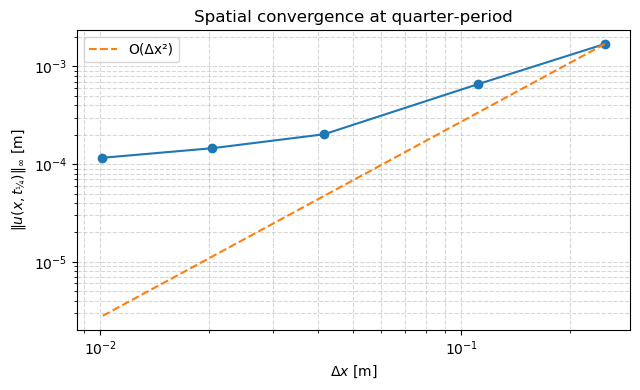

In [194]:
fig2, ax2 = plt.subplots(figsize=(6.5,4))
dxs = [1/4, 1/9, 1/24, 1/49, 1/99]
errors = [max(np.abs(ui5[idx])), max(np.abs(ui10[idx])), max(np.abs(ui25[idx])), max(np.abs(ui50[idx])), max(np.abs(ui100[idx]))]

ax2.loglog(dxs, errors, 'o-', base=10)
# reference O(dx^2)
dx0, err0 = dxs[0], errors[0]
ref = err0 * (np.array(dxs)/dx0)**2
plt.loglog(dxs, ref, '--', label="O(Δx²)")

plt.xlabel(r'$\Delta x$ [m]')
plt.ylabel(r'$\|u(x,t_{¼})\|_\infty$ [m]')
plt.title("Spatial convergence at quarter‑period")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

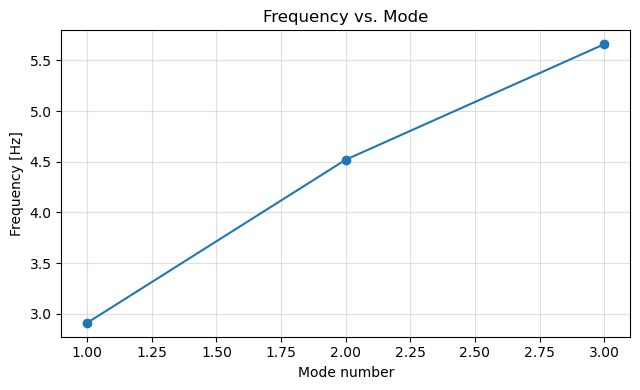

In [218]:
import numpy as np
import matplotlib.pyplot as plt

modes = [1, 2, 3]
freqs = [2.91, 4.52, 5.66] #values were from testing the first cell
fig, ax = plt.subplots(figsize=(6.5,4))
ax.plot(modes, freqs, 'o-')
ax.set_xlabel("Mode number")
ax.set_ylabel("Frequency [Hz]")
ax.set_title("Frequency vs. Mode")
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()